In [26]:
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)


quantificators = ["CC", "ACC", "PCC", "PACC", "HDy","DyS","SMM", "EMQ","MLPE"]
error = "MAE"
dateexperiment = "2022_07_11_18_26"

results_dict={}
print("Loading results... ",sep="")
for quant_name in quantificators:
    results_dict[quant_name] = pd.read_csv("results/prior/results_%s_%s.csv" % (dateexperiment,quant_name),index_col=0)
    results_dict[quant_name]['p_train'] = results_dict[quant_name]['p_train'].round(2)
    results_dict[quant_name]['p_test'] = results_dict[quant_name]['p_test'].round(2)
    results_dict[quant_name]['prior_measure'] = results_dict[quant_name]['p_train']- results_dict[quant_name]['p_test']
    results_dict[quant_name]['prior_measure'] = results_dict[quant_name]['prior_measure'].round(1)
print("Done")

mean_error_methods = {}

writer = pd.ExcelWriter('results/prior/excel/errors_%s.xlsx' % dateexperiment, engine='xlsxwriter')
for quant_name in quantificators:
    results = results_dict[quant_name]
    results_mean = results.groupby(['p_train', 'p_test'])['error'].mean().reset_index()
    #convert to matrix form
    results_mean = results_mean.pivot(index='p_train', columns='p_test', values='error')
    mean_error_methods[quant_name]=results_mean.mean().mean()
    results_mean.columns = results_mean.columns.map(lambda x: "%.2f" % float(x))
    print("Results for method %s. Mean %s: %f" % (quant_name,error, mean_error_methods[quant_name]))
    cm = sns.light_palette('red', as_cmap=True)
    display(results_mean.style.format_index('{:.2f}').format('{:.3f}').background_gradient(cmap=cm,low=0,high=1))

    results_mean.to_excel(writer, sheet_name=quant_name)
    workbook = writer.book
    worksheet = writer.sheets[quant_name]
    # Apply a conditional format to the cell range.
    worksheet.conditional_format('B2:L12', {'type': '2_color_scale','min_type':'num','max_type':'num','min_value':'0','max_value':'1','min_color':'#f3f0f0','max_color':'#ff0000'})
writer.close()

Loading results... 
Done
Results for method CC. Mean MAE: 0.164950


p_test,0.01,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.99
p_train,,,,,,,,,,,
0.01,0.009,0.093,0.190,0.287,0.383,0.481,0.576,0.673,0.769,0.866,0.952
0.10,0.111,0.070,0.032,0.016,0.046,0.088,0.130,0.168,0.208,0.248,0.287
0.20,0.119,0.084,0.051,0.022,0.021,0.051,0.087,0.120,0.154,0.188,0.222
0.30,0.111,0.080,0.053,0.024,0.013,0.033,0.062,0.092,0.121,0.148,0.178
0.40,0.121,0.091,0.065,0.036,0.017,0.018,0.045,0.074,0.103,0.128,0.157
0.50,0.140,0.111,0.084,0.055,0.032,0.011,0.027,0.055,0.083,0.110,0.138
0.60,0.159,0.127,0.102,0.073,0.048,0.020,0.017,0.039,0.068,0.095,0.124
0.70,0.176,0.145,0.118,0.088,0.063,0.032,0.013,0.028,0.056,0.085,0.114
0.80,0.220,0.185,0.154,0.119,0.091,0.057,0.025,0.020,0.044,0.077,0.110


Results for method ACC. Mean MAE: 0.081095


p_test,0.01,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.99
p_train,,,,,,,,,,,
0.01,0.161,0.185,0.256,0.323,0.383,0.398,0.408,0.394,0.369,0.338,0.308
0.10,0.020,0.028,0.038,0.047,0.061,0.067,0.082,0.086,0.084,0.061,0.012
0.20,0.015,0.019,0.023,0.025,0.031,0.032,0.039,0.040,0.045,0.046,0.012
0.30,0.017,0.018,0.022,0.020,0.024,0.023,0.029,0.027,0.030,0.032,0.011
0.40,0.014,0.018,0.019,0.019,0.020,0.017,0.021,0.022,0.021,0.023,0.011
0.50,0.012,0.019,0.020,0.019,0.019,0.016,0.021,0.019,0.020,0.019,0.011
0.60,0.011,0.027,0.027,0.024,0.021,0.018,0.022,0.018,0.018,0.016,0.014
0.70,0.013,0.029,0.028,0.026,0.022,0.019,0.020,0.019,0.018,0.017,0.014
0.80,0.012,0.039,0.041,0.036,0.030,0.028,0.029,0.024,0.022,0.021,0.020


Results for method PCC. Mean MAE: 0.157725


p_test,0.01,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.99
p_train,,,,,,,,,,,
0.01,0.456,0.369,0.271,0.172,0.073,0.027,0.125,0.224,0.322,0.421,0.510
0.10,0.242,0.181,0.115,0.047,0.018,0.086,0.153,0.220,0.286,0.353,0.414
0.20,0.137,0.094,0.048,0.012,0.046,0.094,0.140,0.189,0.235,0.281,0.325
0.30,0.105,0.070,0.036,0.010,0.035,0.073,0.108,0.146,0.181,0.217,0.252
0.40,0.135,0.102,0.069,0.034,0.011,0.033,0.066,0.103,0.136,0.169,0.202
0.50,0.170,0.137,0.104,0.069,0.039,0.010,0.029,0.064,0.097,0.131,0.163
0.60,0.210,0.175,0.142,0.107,0.075,0.039,0.013,0.031,0.065,0.100,0.133
0.70,0.262,0.226,0.190,0.151,0.119,0.082,0.044,0.012,0.029,0.066,0.100
0.80,0.331,0.285,0.238,0.189,0.145,0.095,0.047,0.008,0.049,0.097,0.141


Results for method PACC. Mean MAE: 0.036700


p_test,0.01,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.99
p_train,,,,,,,,,,,
0.01,0.015,0.053,0.060,0.067,0.084,0.101,0.124,0.134,0.131,0.090,0.010
0.10,0.011,0.029,0.029,0.029,0.038,0.042,0.057,0.064,0.077,0.073,0.010
0.20,0.010,0.018,0.019,0.020,0.027,0.028,0.037,0.041,0.049,0.055,0.011
0.30,0.013,0.015,0.017,0.018,0.023,0.023,0.030,0.030,0.034,0.039,0.010
0.40,0.011,0.019,0.019,0.017,0.018,0.016,0.021,0.022,0.023,0.028,0.010
0.50,0.011,0.018,0.018,0.017,0.017,0.014,0.020,0.020,0.021,0.022,0.010
0.60,0.010,0.028,0.025,0.022,0.019,0.015,0.018,0.017,0.015,0.017,0.010
0.70,0.011,0.032,0.029,0.027,0.021,0.016,0.018,0.017,0.017,0.017,0.010
0.80,0.012,0.046,0.043,0.038,0.029,0.023,0.022,0.018,0.016,0.016,0.010


Results for method HDy. Mean MAE: 0.037134


p_test,0.01,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.99
p_train,,,,,,,,,,,
0.01,0.014,0.041,0.069,0.096,0.116,0.136,0.157,0.176,0.190,0.204,0.208
0.10,0.010,0.022,0.028,0.027,0.028,0.029,0.031,0.032,0.032,0.036,0.025
0.20,0.008,0.024,0.028,0.029,0.027,0.029,0.031,0.029,0.029,0.028,0.020
0.30,0.005,0.019,0.021,0.019,0.019,0.018,0.019,0.018,0.017,0.016,0.011
0.40,0.005,0.017,0.019,0.018,0.018,0.016,0.018,0.017,0.015,0.015,0.009
0.50,0.006,0.016,0.018,0.017,0.019,0.016,0.019,0.017,0.016,0.014,0.007
0.60,0.009,0.016,0.019,0.018,0.019,0.018,0.020,0.018,0.017,0.016,0.007
0.70,0.010,0.017,0.021,0.021,0.024,0.021,0.023,0.021,0.020,0.016,0.007
0.80,0.011,0.023,0.027,0.026,0.026,0.026,0.027,0.023,0.024,0.021,0.011


Results for method DyS. Mean MAE: 0.031321


p_test,0.01,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.99
p_train,,,,,,,,,,,
0.01,0.022,0.042,0.063,0.080,0.098,0.120,0.136,0.160,0.172,0.192,0.193
0.10,0.011,0.016,0.020,0.023,0.028,0.029,0.034,0.037,0.039,0.037,0.029
0.20,0.009,0.015,0.017,0.019,0.022,0.022,0.025,0.026,0.027,0.027,0.020
0.30,0.010,0.014,0.017,0.016,0.018,0.016,0.019,0.019,0.018,0.017,0.011
0.40,0.009,0.012,0.016,0.016,0.017,0.014,0.017,0.017,0.015,0.014,0.012
0.50,0.011,0.015,0.017,0.016,0.019,0.016,0.020,0.018,0.016,0.015,0.011
0.60,0.012,0.019,0.020,0.019,0.019,0.016,0.019,0.018,0.015,0.015,0.011
0.70,0.019,0.021,0.022,0.021,0.022,0.018,0.020,0.018,0.015,0.014,0.009
0.80,0.010,0.019,0.022,0.020,0.022,0.020,0.021,0.019,0.019,0.017,0.010


Results for method SMM. Mean MAE: 0.032414


p_test,0.01,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.99
p_train,,,,,,,,,,,
0.01,0.023,0.037,0.047,0.058,0.073,0.089,0.105,0.115,0.109,0.092,0.055
0.10,0.012,0.017,0.020,0.020,0.026,0.025,0.034,0.037,0.038,0.042,0.019
0.20,0.013,0.019,0.021,0.022,0.026,0.024,0.029,0.029,0.032,0.032,0.019
0.30,0.013,0.018,0.020,0.019,0.020,0.018,0.023,0.022,0.024,0.025,0.015
0.40,0.014,0.016,0.017,0.017,0.020,0.017,0.022,0.021,0.022,0.023,0.015
0.50,0.014,0.018,0.020,0.018,0.020,0.017,0.021,0.020,0.019,0.019,0.013
0.60,0.014,0.021,0.022,0.018,0.018,0.015,0.018,0.017,0.016,0.015,0.011
0.70,0.014,0.027,0.027,0.023,0.022,0.018,0.018,0.017,0.015,0.014,0.010
0.80,0.027,0.031,0.031,0.024,0.026,0.021,0.021,0.018,0.017,0.016,0.013


Results for method EMQ. Mean MAE: 0.032629


p_test,0.01,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.99
p_train,,,,,,,,,,,
0.01,0.036,0.059,0.084,0.104,0.128,0.139,0.146,0.147,0.129,0.080,0.009
0.10,0.009,0.015,0.019,0.019,0.025,0.025,0.027,0.027,0.025,0.022,0.013
0.20,0.007,0.014,0.017,0.017,0.021,0.020,0.023,0.022,0.021,0.017,0.012
0.30,0.007,0.014,0.016,0.015,0.018,0.016,0.018,0.016,0.015,0.013,0.011
0.40,0.006,0.014,0.015,0.014,0.016,0.014,0.017,0.017,0.016,0.013,0.008
0.50,0.006,0.015,0.016,0.015,0.016,0.014,0.019,0.017,0.017,0.014,0.008
0.60,0.006,0.017,0.019,0.017,0.016,0.013,0.017,0.015,0.013,0.011,0.008
0.70,0.006,0.018,0.018,0.019,0.017,0.014,0.017,0.015,0.013,0.011,0.008
0.80,0.007,0.023,0.023,0.023,0.020,0.017,0.019,0.016,0.014,0.012,0.009


Results for method MLPE. Mean MAE: 0.360661


p_test,0.01,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.99
p_train,,,,,,,,,,,
0.01,0.000,0.088,0.188,0.289,0.389,0.490,0.590,0.690,0.790,0.890,0.980
0.10,0.090,0.002,0.099,0.199,0.299,0.400,0.500,0.600,0.700,0.800,0.890
0.20,0.190,0.102,0.001,0.099,0.199,0.300,0.400,0.500,0.600,0.700,0.790
0.30,0.290,0.202,0.101,0.001,0.099,0.200,0.300,0.400,0.500,0.600,0.690
0.40,0.390,0.302,0.201,0.101,0.001,0.100,0.200,0.300,0.400,0.500,0.590
0.50,0.490,0.402,0.302,0.201,0.101,0.000,0.100,0.200,0.300,0.400,0.490
0.60,0.590,0.502,0.402,0.301,0.201,0.100,0.000,0.100,0.200,0.300,0.390
0.70,0.690,0.602,0.502,0.401,0.301,0.200,0.100,0.000,0.100,0.200,0.290
0.80,0.790,0.702,0.602,0.501,0.401,0.300,0.200,0.100,0.000,0.100,0.190


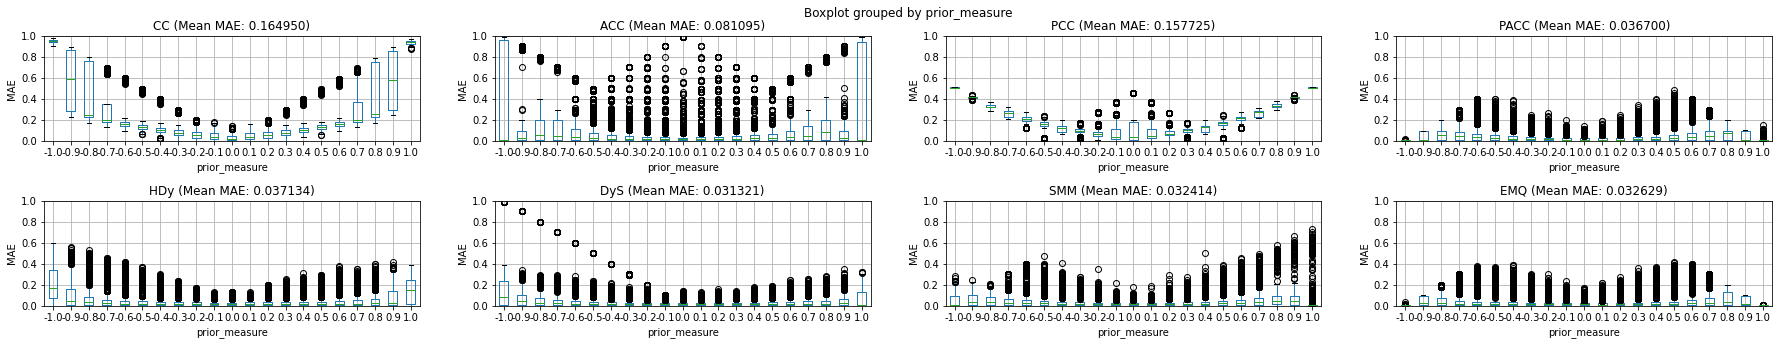

In [31]:
quantificators = ["CC", "ACC", "PCC", "PACC", "HDy","DyS","SMM", "EMQ"]
n_cols=4
fig, ax = plt.subplots(2,n_cols,figsize=(30,5))
pd.set_option('display.max_rows', 500)

for k,quant_name in enumerate(quantificators):
    results = results_dict[quant_name]
    ax[k//n_cols][k%n_cols].set_ylim(0, 1)
    ax[k//n_cols][k%n_cols].set_ylabel(error)
    ax[k//n_cols][k%n_cols].tick_params(axis='x', rotation=90)
    fig.tight_layout()
    results.boxplot(ax=ax[k//n_cols][k%n_cols],column='error',by='prior_measure')
    ax[k//n_cols][k%n_cols].set_title("%s (Mean %s: %f)"  % (quant_name,error,mean_error_methods[quant_name]))

### Tables and charts to be included in a paper

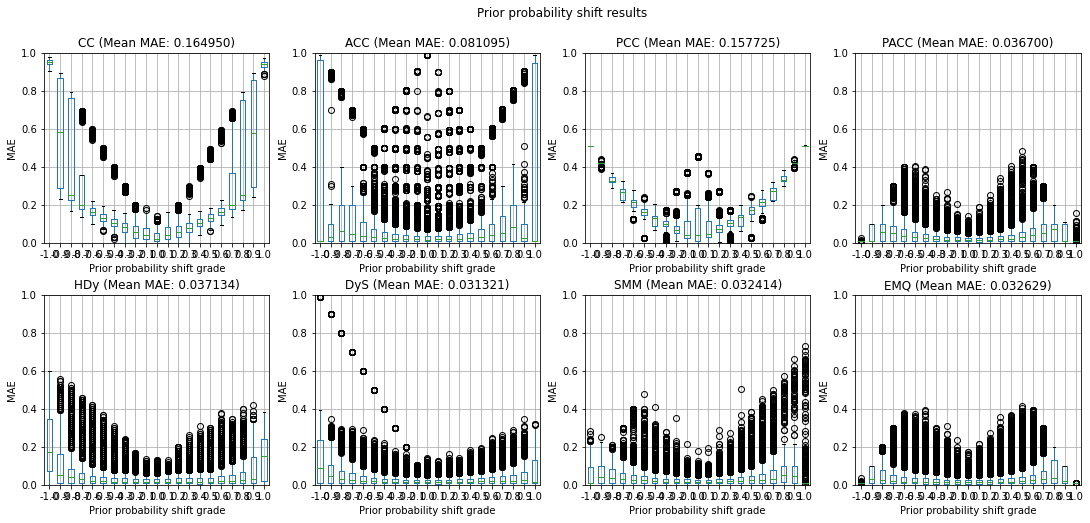

In [28]:
quantificators = ["CC", "ACC", "PCC", "PACC", "HDy","DyS","SMM", "EMQ"]
n_cols = 4
fig, ax = plt.subplots(2,n_cols,figsize=(18,8))
for k,quant_name in enumerate(quantificators):
    results = results_dict[quant_name]
    ax[k//n_cols][k%n_cols].set_ylim(0, 1)
    ax[k//n_cols][k%n_cols].set_ylabel(error)
    ax[k//n_cols][k%n_cols].tick_params(axis='x', rotation=90)
    fig.tight_layout()
    results.boxplot(ax=ax[k//n_cols][k%n_cols],column='error',by='prior_measure')
    plt.suptitle('Prior probability shift results')
    ax[k//n_cols][k%n_cols].set_xlabel("Prior probability shift grade")
    ax[k//n_cols][k%n_cols].set_title("%s (Mean %s: %f)"  % (quant_name,error,mean_error_methods[quant_name]))
plt.savefig("images/prior.pdf",format='pdf',bbox_inches='tight')
plt.savefig("images/prior.png",format='png',bbox_inches='tight')

## Main table to put in the paper with results for prior probability shift

In [27]:
from utils.wilcoxon import wilcoxon_test
quantificators = ["CC", "ACC", "PCC", "PACC", "HDy","DyS","SMM", "EMQ"]
global_results = pd.DataFrame(columns = quantificators,index=np.linspace(-1,1,21).round(1),dtype=float)
for k,quant_name in enumerate(quantificators):
    results = results_dict[quant_name]
    results = results.groupby(by='prior_measure')['error'].mean()
    global_results.loc[:, quant_name] = results
print(global_results)

global_results_style = global_results.style.format('{:.3f}').format_index('{:.1f}')

#We want to make a statistical test for each row, to compare methods for the same degree of covariate shift
for i,r in global_results.iterrows():
        #compute the best method for this experiment
        prior_measure = r.name
        best_method = r.index[r.argmin()]
        
        #print("Computing statistical test for experiment covariate degree=%f, p_test=%s. Winner method %s" % (covariate_measure,p_test,best_method))
        #Get data for the winner method
        results_best = results_dict[best_method].loc[(results_dict[best_method]['prior_measure']==prior_measure),'error'].to_numpy()
        #We need to get all the rows in results that matches this experiment for each method
        for quant_name in quantificators:
            if quant_name!=best_method:
                #print("Comparing %s with %s" % (best_method,quant_name))
                results_method = results_dict[quant_name].loc[results_dict[quant_name]['prior_measure']==prior_measure,'error'].to_numpy()
                global_results_style.set_properties(subset=(prior_measure, quant_name),**wilcoxon_test(results_best,results_method))


result = global_results_style.highlight_min(axis=1,props='textbf:--rwrap;')
display(result)
columns = 'r'*len(quantificators)
print(result.to_latex(hrules=True,column_format="l|"+columns))

            CC       ACC       PCC      PACC       HDy       DyS       SMM       EMQ
-1.0  0.952072  0.307990  0.509770  0.009981  0.207564  0.193450  0.054889  0.009257
-0.9  0.576404  0.174543  0.417381  0.050090  0.114989  0.110621  0.055328  0.046372
-0.8  0.412879  0.147579  0.333476  0.071544  0.082155  0.076291  0.056441  0.054357
-0.7  0.311675  0.133744  0.260633  0.068828  0.062005  0.059183  0.049982  0.049914
-0.6  0.240608  0.116330  0.199829  0.057309  0.048571  0.045787  0.042680  0.042842
-0.5  0.186413  0.097409  0.147059  0.045160  0.039264  0.037253  0.035349  0.037232
-0.4  0.140737  0.081432  0.120921  0.035395  0.032796  0.030318  0.028762  0.032805
-0.3  0.101383  0.064643  0.099124  0.029081  0.028595  0.025702  0.024580  0.027464
-0.2  0.069251  0.050304  0.093368  0.024571  0.024620  0.022001  0.021727  0.022996
-0.1  0.050451  0.038910  0.099345  0.021963  0.022052  0.019440  0.019938  0.019583
 0.0  0.032914  0.041559  0.129732  0.019665  0.020731  0.018329 

,CC,ACC,PCC,PACC,HDy,DyS,SMM,EMQ
-1.0,0.952,0.308,0.510,0.010,0.208,0.193,0.055,0.009
-0.9,0.576,0.175,0.417,0.050,0.115,0.111,0.055,0.046
-0.8,0.413,0.148,0.333,0.072,0.082,0.076,0.056,0.054
-0.7,0.312,0.134,0.261,0.069,0.062,0.059,0.050,0.050
-0.6,0.241,0.116,0.200,0.057,0.049,0.046,0.043,0.043
-0.5,0.186,0.097,0.147,0.045,0.039,0.037,0.035,0.037
-0.4,0.141,0.081,0.121,0.035,0.033,0.030,0.029,0.033
-0.3,0.101,0.065,0.099,0.029,0.029,0.026,0.025,0.027
-0.2,0.069,0.050,0.093,0.025,0.025,0.022,0.022,0.023
-0.1,0.050,0.039,0.099,0.022,0.022,0.019,0.020,0.020


\begin{tabular}{l|rrrrrrrr}
\toprule
 & CC & ACC & PCC & PACC & HDy & DyS & SMM & EMQ \\
\midrule
-1.0 & 0.952 & 0.308 & 0.510 & 0.010 & 0.208 & 0.193 & 0.055 & \textbf{0.009} \\
-0.9 & 0.576 & 0.175 & 0.417 & 0.050 & 0.115 & 0.111 & 0.055 & \textbf{0.046} \\
-0.8 & 0.413 & 0.148 & 0.333 & 0.072 & 0.082 & 0.076 & 0.056 & \textbf{0.054} \\
-0.7 & 0.312 & 0.134 & 0.261 & 0.069 & 0.062 & 0.059 & 0.050 & \textbf{0.050} \\
-0.6 & 0.241 & 0.116 & 0.200 & 0.057 & \ddag{0.049} & \dag{0.046} & \textbf{0.043} & 0.043 \\
-0.5 & 0.186 & 0.097 & 0.147 & 0.045 & \dag{0.039} & 0.037 & \textbf{0.035} & 0.037 \\
-0.4 & 0.141 & 0.081 & 0.121 & 0.035 & \ddag{0.033} & \dag{0.030} & \textbf{0.029} & 0.033 \\
-0.3 & 0.101 & 0.065 & 0.099 & 0.029 & \dag{0.029} & \dag{0.026} & \textbf{0.025} & 0.027 \\
-0.2 & 0.069 & 0.050 & 0.093 & 0.025 & 0.025 & \dag{0.022} & \textbf{0.022} & 0.023 \\
-0.1 & 0.050 & 0.039 & 0.099 & 0.022 & 0.022 & \textbf{0.019} & \dag{0.020} & 0.020 \\
0.0 & 0.033 & 0.042 & 0.130 & 0.020 

In [6]:
for quant_name in quantificators:
    results = pd.read_csv("results/prior/results_%s_%s.csv" % (dateexperiment,quant_name),index_col=0)
    results['p_train'] = results['p_train'].round(2)
    results['p_test'] = results['p_test'].round(2)
    results_mean = results.groupby(['p_train', 'p_test'])['error'].mean().reset_index()
    #convert to matrix form
    results_mean = results_mean.pivot(index='p_train', columns='p_test', values='error')
    mean_error_methods[quant_name]=results_mean.mean().mean()
    results_mean.columns = results_mean.columns.map(lambda x: "%.2f" % float(x))
    results_mean.columns.name=None
    results_mean.index.name=None
    cm = sns.light_palette('red', as_cmap=True)
    f = open("tables/prior/results_%s.tex" % (quant_name), "w")
    f.write(results_mean.style.format_index('{:.2f}').format('{:.3f}').background_gradient(cmap=cm,low=0,high=1).to_latex(convert_css=True,
                                caption="Results for \emph{prior probability shift} for method %s. In rows, prevalence for the train set; in columns, prevalence for test sample. Mean %s: %f." % (quant_name,error,mean_error_methods[quant_name]),
                                column_format='lccccccccccc', position='H',label="tab:prior%s"%quant_name))
    f.close()